# Northwind database analysis

## Executive Summary 

In [1]:
#imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from math import sqrt
import scipy.stats as stats
from sklearn import preprocessing

from datetime import datetime


In [2]:
# create the SQL engine
# to use the large version of the databse:
# engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)

# to use the small version of the databse:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
con = engine.connect()
Session = sessionmaker(bind=engine)
session = Session()


2019-04-24 10:11:33,114 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-24 10:11:33,117 INFO sqlalchemy.engine.base.Engine ()
2019-04-24 10:11:33,119 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-24 10:11:33,120 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# have a look at the tables
inspector = inspect(engine)
print(inspector.get_table_names())


2019-04-24 10:11:33,127 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-24 10:11:33,129 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [4]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

get_columns_info('OrderDetail')




2019-04-24 10:11:33,145 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-04-24 10:11:33,147 INFO sqlalchemy.engine.base.Engine ()
Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


In [5]:
def make_column_list(table):
    cols = []  #make an empty list
    cols_dict = inspector.get_columns(table)  # make a dict of the column names from the SQL table
#     print(cols_list)
    for column in cols_dict:
        cols.append(column['name'])
#     print(cols)
    return cols


In [6]:
# small sample of order detail for testing
# rs = con.execute('SELECT * FROM OrderDetail LIMIT 25')

# get full orderdetail
rs = con.execute('SELECT * FROM OrderDetail')
order_detail = pd.DataFrame(rs.fetchall())

column_names = make_column_list('OrderDetail')
order_detail.columns = column_names

order_detail.head()

2019-04-24 10:11:33,167 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-04-24 10:11:33,169 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
column_names = make_column_list('Order')
column_names

2019-04-24 10:11:33,212 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-04-24 10:11:33,215 INFO sqlalchemy.engine.base.Engine ()


['Id',
 'CustomerId',
 'EmployeeId',
 'OrderDate',
 'RequiredDate',
 'ShippedDate',
 'ShipVia',
 'Freight',
 'ShipName',
 'ShipAddress',
 'ShipCity',
 'ShipRegion',
 'ShipPostalCode',
 'ShipCountry']

In [8]:
# customer table to pandas dataframe
rs = con.execute('SELECT * FROM Customer')
customers = pd.DataFrame(rs.fetchall())
column_names = make_column_list('Customer')
customers.columns = column_names

customers.head(10)


2019-04-24 10:11:33,228 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-04-24 10:11:33,231 INFO sqlalchemy.engine.base.Engine ()
2019-04-24 10:11:33,237 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-04-24 10:11:33,239 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745


In [9]:
# test orders table
# rs = con.execute('SELECT * FROM [Order]')
# orders = pd.DataFrame(rs.fetchall())
# orders.head()


# get full orders
rs = con.execute('SELECT * FROM [Order]')
orders = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Order')
orders.columns = column_names



2019-04-24 10:11:33,262 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-04-24 10:11:33,264 INFO sqlalchemy.engine.base.Engine ()


In [10]:
# correct the incorect CustomerId values in orders_count
orders['CustomerId'].replace('ANTO', 'ANTON', inplace=True)
orders['CustomerId'].replace('DUMO', 'DUMON', inplace=True)
orders['CustomerId'].replace('OCEA', 'OCEAN', inplace=True)
orders['CustomerId'].replace('QUEE', 'QUEEN', inplace=True)
orders

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
5,10253,HANAR,3,2012-07-10,2012-07-24,2012-07-16,2,58.17,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
6,10254,CHOPS,5,2012-07-11,2012-08-08,2012-07-23,2,22.98,Chop-suey Chinese,Hauptstr. 31,Bern,Western Europe,3012,Switzerland
7,10255,RICSU,9,2012-07-12,2012-08-09,2012-07-15,3,148.33,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
8,10256,WELLI,3,2012-07-15,2012-08-12,2012-07-17,2,13.97,Wellington Importadora,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil
9,10257,HILAA,4,2012-07-16,2012-08-13,2012-07-22,3,81.91,HILARION-Abastos,Carrera 22 con Ave. Carlos Soublette #8-35,San Cristóbal,South America,5022,Venezuela


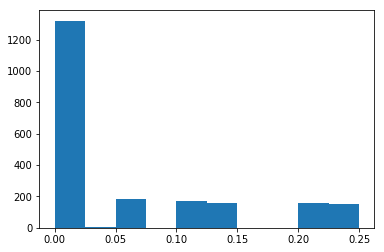

In [11]:
plt.hist(order_detail["Discount"])
plt.show()

In [12]:
# make a new column to calculate the line item total
order_detail['line_total'] = order_detail['Quantity'] * order_detail['UnitPrice'] * (1 - order_detail['Discount'])

order_detail.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [13]:
order_detail.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,587.374960
std,241.378032,22.159019,29.827418,19.022047,0.083450,969.224235
min,10248.000000,1.000000,2.000000,1.000000,0.000000,4.800000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,147.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,337.750000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,656.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,15810.000000


Idea: Compare orders that contain at least one discounted item to orders that have no discounts.
* Is the average order total higher?
* Is the count of total items ordered higher?
* Is the count of unique products higher?

From prior labs:
q = """SELECT LastName, FirstName, COUNT(*) as TerritoriesAssigned from \
Employee \
JOIN EmployeeTerritory et on Employee.Id = et.employeeId \
GROUP BY Employee.lastname \
ORDER BY TerritoriesAssigned DESC"""

In [14]:
# rs = con.execute('SELECT * FROM [Order] JOIN OrderDetail on Order.OrderID = OrderDetail.OrderID WHERE OrderDetail.Discount > 0')
rs = con.execute('SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0')

orders_with_discount = pd.DataFrame(rs.fetchall())

orders_with_discount.columns = ['Id']

orders_with_discount.count()
orders_with_discount.head()


2019-04-24 10:11:33,901 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0
2019-04-24 10:11:33,904 INFO sqlalchemy.engine.base.Engine ()


,Id
0,10250
1,10251
2,10252
3,10254
4,10258


In [15]:
# make a list of orders that have no discounted items
orders_without_discount = orders.merge(orders_with_discount.drop_duplicates(), on=['Id'], how='left', indicator=True)

orders_without_discount = orders_without_discount[orders_without_discount._merge != 'both']

# orders_without_discount.head()

orders_without_discount.count()

# sources
# https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe
# https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/

Id                450
CustomerId        450
EmployeeId        450
OrderDate         450
RequiredDate      450
ShippedDate       440
ShipVia           450
Freight           450
ShipName          450
ShipAddress       450
ShipCity          450
ShipRegion        450
ShipPostalCode    446
ShipCountry       450
_merge            450
dtype: int64

In [16]:
orders.count()

Id                830
CustomerId        830
EmployeeId        830
OrderDate         830
RequiredDate      830
ShippedDate       809
ShipVia           830
Freight           830
ShipName          830
ShipAddress       830
ShipCity          830
ShipRegion        830
ShipPostalCode    811
ShipCountry       830
dtype: int64

In [17]:
orders_with_discount.count()

Id    380
dtype: int64

In [18]:
orders_without_discount.count()

Id                450
CustomerId        450
EmployeeId        450
OrderDate         450
RequiredDate      450
ShippedDate       440
ShipVia           450
Freight           450
ShipName          450
ShipAddress       450
ShipCity          450
ShipRegion        450
ShipPostalCode    446
ShipCountry       450
_merge            450
dtype: int64

830 orders:
* 450 orders have no discounts on any item
* 380 orders have at least one discounted product in the order.
* 19 orders have no value for ShipPostalCode.
* 21 orders have no value for ShippedDate.

In [19]:
rs = con.execute('SELECT * FROM OrderDetail JOIN [Order] on OrderDetail.Id = [Order].Id')
temp_df = pd.DataFrame(rs.fetchall())
temp_df.head(10)

2019-04-24 10:11:33,980 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail JOIN [Order] on OrderDetail.Id = [Order].Id
2019-04-24 10:11:33,983 INFO sqlalchemy.engine.base.Engine ()


""


Idea - Make a pandas dataframe of all orders where there is any item with a discount. 
Within those orders, what are the summary statistics for:
* The number of different SKU's in the order 
* Quantity of each SKU ordered. How does this compare to orders where the samei SKU has been ordered but there was no discount.
* 

And then compare those statistics to orders where there was no item with a discount.










add these columns to the order dataframe: 
* order_total
* unique_products_count
* all_items_total_qty_count

In [20]:
order_detail.head()
print(order_detail.loc[order_detail['OrderId'] == 10248])
# print(df.loc[df['A'] == 'foo'])

         Id  OrderId  ProductId  UnitPrice  Quantity  Discount  line_total
0  10248/11    10248         11       14.0        12       0.0       168.0
1  10248/42    10248         42        9.8        10       0.0        98.0
2  10248/72    10248         72       34.8         5       0.0       174.0


In [21]:
# add blank columns to orders dataframe
orders['order_total'] = 0
orders['unique_products_count'] = 0
orders['all_items_total_qty_count'] = 0
orders['discount_flag'] = False #True if order contains any discounted items, otherwise False

orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,0,0,0,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,0,0,0,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,0,0,0,False
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,0,0,0,False
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,0,0,0,False


In [22]:
# get new column values, add to orders dataframe
for index, row in orders.iterrows():
    order_id = row['Id']     #row['Id'] gets the OrderId column value
    order_index =  orders.loc[orders['Id'] == order_id].index   #  order_index:  Int64Index([0], dtype='int64')
    
#     print ("order_id: ", order_id)
#     print ("order_index: ", order_index[0])  
    
# get the relevant rows from order_detail
    temp_df = order_detail.loc[order_detail['OrderId'] == order_id]
#     print(temp_df)
    
    order_total = 0
    order_product_ids_count = 0
    product_ids = []
    all_items_total_qty_count = 0
    discount_flag = False
    for index, row in temp_df.iterrows():
#         print(row)
        #for testing
#         print("UnitPrice: {}, Quantity: {}, Discount: {} ".format(row['UnitPrice'], row['Quantity'], row['Discount']))
        order_total += round((row['UnitPrice'] * row['Quantity']) * (1 - row['Discount']),2)
        #for testing
#     print("order_total: {}".format(order_total))
    
    #get the unique product id's
        product_ids.append(row['ProductId'])
        
    #count up the total # of units of all products in the order
        all_items_total_qty_count += row['Quantity']
        
    #check if any discount
        if discount_flag == False:
            if row['Discount'] > 0:
                discount_flag = True
    
    #make a set (only unique values)
    product_ids = set(product_ids)
    
# add these values to the order in the orders dataframe

#     print("Order {} complete. Order amount: {} - unique items: {} - item count: {}"
#           .format(order_id, order_total, len(product_ids), all_items_total_qty_count))
    
#     orders.iloc[order_index[0],'order_total'] = order_total
#     orders.ix[order_index[0], 'order_total'] = order_total  # .ix has been deprecated
    orders.iloc[order_index[0], orders.columns.get_loc('order_total')] = order_total
    orders.iloc[order_index[0], orders.columns.get_loc('unique_products_count')] = len(product_ids)
    orders.iloc[order_index[0], orders.columns.get_loc('all_items_total_qty_count')] = all_items_total_qty_count
    orders.iloc[order_index[0], orders.columns.get_loc('discount_flag')] = discount_flag
#     print(orders.iloc[order_index[0]])
#     print(orders.loc[orders['Id'] == order_id])
#               df.loc[df['column_name'] == some_value]
    

In [23]:
# make Id the index of orders dataframe
# orders.set_index('Id', inplace=True)

# look at orders
orders.head()



,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.00,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.40,2,49,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True


In [24]:

# discount_list = orders_with_discount['Id'].tolist()
# discount_list


In [25]:
# no_discount_list = orders_without_discount['Id'].tolist()
# no_discount_list


In [26]:
discount = orders[orders['discount_flag'] == True]
discount.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True
6,10254,CHOPS,5,2012-07-11,2012-08-08,2012-07-23,2,22.98,Chop-suey Chinese,Hauptstr. 31,Bern,Western Europe,3012,Switzerland,556.62,3,57,True
10,10258,ERNSH,1,2012-07-17,2012-08-14,2012-07-23,1,140.51,Ernst Handel,Kirchgasse 6,Graz,Western Europe,8010,Austria,1614.88,3,121,True


In [27]:
# no_discount = orders[orders['Id'].isin(no_discount_list)]
# no_discount.head()

no_discount = orders[orders['discount_flag'] == False]
no_discount.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.0,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.4,2,49,False
5,10253,HANAR,3,2012-07-10,2012-07-24,2012-07-16,2,58.17,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1444.8,3,102,False
7,10255,RICSU,9,2012-07-12,2012-08-09,2012-07-15,3,148.33,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland,2490.5,4,110,False
8,10256,WELLI,3,2012-07-15,2012-08-12,2012-07-17,2,13.97,Wellington Importadora,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil,517.8,2,27,False


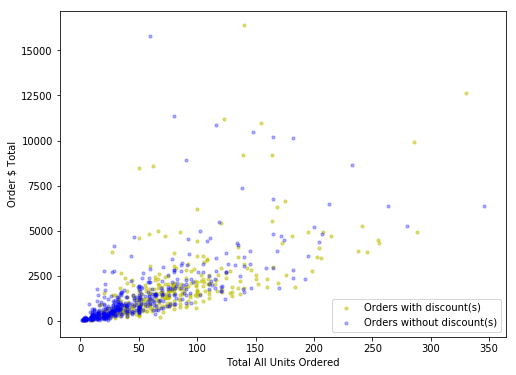

In [28]:
#original
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['all_items_total_qty_count'], discount['order_total'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['all_items_total_qty_count'], no_discount['order_total'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Total All Units Ordered")
ax.set_ylabel("Order $ Total")
plt.legend(loc='lower right')


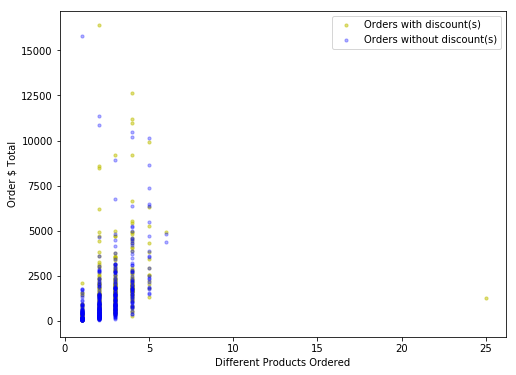

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['unique_products_count'], discount['order_total'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['unique_products_count'], no_discount['order_total'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Different Products Ordered")
ax.set_ylabel("Order $ Total")
plt.legend(loc='upper right')


#redu this plot to make a better visualization

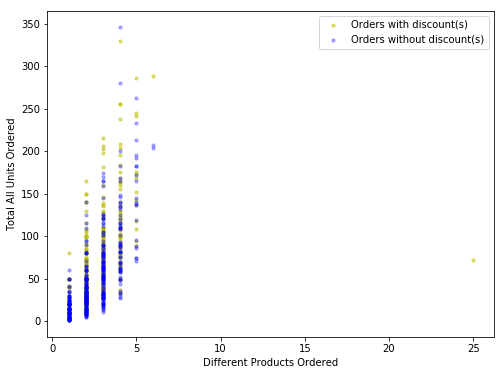

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['unique_products_count'], discount['all_items_total_qty_count'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['unique_products_count'], no_discount['all_items_total_qty_count'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Different Products Ordered")
ax.set_ylabel("Total All Units Ordered")
plt.legend(loc='upper right')


#redu this plot to make a better visualization

Next Steps:
* create totals for each customer:
    * total number of orders
    * total $ value of all orders
    * first order date
    * last order date
    * average orders/month (year?, etc.)
    






In [31]:
# add columns to customer dataframe: orders_count, orders_value, first_order_date, last_order_date
customers['orders_count'] = 0
customers['orders_value'] = 0
customers['first_order_date'] = 0
customers['last_order_date'] = 0

# cast date columns as pandas datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers.head()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,0,0,1970-01-01,1970-01-01
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,0,0,1970-01-01,1970-01-01
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,0,0,1970-01-01,1970-01-01
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,0,0,1970-01-01,1970-01-01
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,0,0,1970-01-01,1970-01-01


In [32]:
#get orders count
orders_count = orders.groupby("CustomerId")["Id"].nunique()
orders_count.head(10)

CustomerId
ALFKI     6
ANATR     4
ANTON     7
AROUT    13
BERGS    18
BLAUS     7
BLONP    11
BOLID     3
BONAP    17
BOTTM    14
Name: Id, dtype: int64

In [33]:
orders_count = orders_count.reset_index()
# orders_count.describe()
orders_count.head(10)

,CustomerId,Id
0,ALFKI,6
1,ANATR,4
2,ANTON,7
3,AROUT,13
4,BERGS,18
5,BLAUS,7
6,BLONP,11
7,BOLID,3
8,BONAP,17
9,BOTTM,14


In [34]:
# data.rename(columns={'gdp':'log(gdp)'}, inplace=True)
orders_count.rename(columns={'Id':'order_count'}, inplace=True)

In [35]:
orders_count.describe()

,order_count
count,89.000000
mean,9.325843
std,5.810991
min,1.000000
25%,5.000000
50%,8.000000
75%,12.000000
max,31.000000


In [36]:
# add order count to each customer record

for index, row in orders_count.iterrows():
#     print(row['CustomerId'])
#     print(row['order_count'])
#     break
    customer_id = row['CustomerId']
    order_count = row['order_count']
    customer_index = "NONE"
    
    # all customer id's in the customer table had five digits
    # this if/else statement was used to identify orders where the customer id was not five digits long
    if len(customer_id) == 5:                               
        customer_index = customers.loc[customers['Id'] == customer_id].index
        customers.iloc[customer_index, customers.columns.get_loc('orders_count')] = order_count
    else:
        print('CustomerId: {}'.format(customer_id))
        print('Order Count: {}'.format(order_count))
        print('Customer Index: {}'.format(customer_index))
        

    

In [37]:
#calculate customers total value of all orders
orders_total = orders.groupby("CustomerId")['order_total'].agg(sum)

orders_total = orders_total.reset_index()
orders_total.head()

,CustomerId,order_total
0,ALFKI,4273.00
1,ANATR,1402.95
2,ANTON,7023.98
3,AROUT,13390.65
4,BERGS,24927.58


In [38]:
# add the total value of all orders to each customer
for index, row in orders_total.iterrows():
    customer_id = row['CustomerId']
    order_total = row['order_total']
    customer_index = customers.loc[customers['Id'] == customer_id].index
    customers.iloc[customer_index,customers.columns.get_loc('orders_value')] = order_total

In [39]:
customers.head(10)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,1970-01-01,1970-01-01
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,1970-01-01,1970-01-01
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,1970-01-01,1970-01-01
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,1970-01-01,1970-01-01
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,1970-01-01,1970-01-01
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924,7,3239.80,1970-01-01,1970-01-01
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32,11,18534.08,1970-01-01,1970-01-01
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99,3,4232.85,1970-01-01,1970-01-01
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41,17,21963.24,1970-01-01,1970-01-01
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745,14,20801.59,1970-01-01,1970-01-01


In [40]:
customers.describe()

,orders_count,orders_value
count,91.000000,91.000000
mean,9.120879,13909.813297
std,5.908253,20103.531743
min,0.000000,0.000000
25%,5.000000,3166.755000
50%,8.000000,7023.980000
75%,12.000000,16646.830000
max,31.000000,110277.320000


In [41]:
# inspect the count of orders for customers

order_counts = customers.groupby('orders_count')['orders_count'].count()
order_counts
# order_counts = order_counts.reset_index()

orders_count
0      2
1      1
2      2
3      7
4      6
5     10
6      8
7      7
8      4
9      5
10    11
11     4
12     3
13     3
14     6
15     3
17     1
18     3
19     2
28     1
30     1
31     1
Name: orders_count, dtype: int64

Two customers have no order, one customer has only one order.

In [42]:
under_two_orders = customers.loc[customers['orders_count'] < 2]
print (under_two_orders)

       Id                           CompanyName      ContactName  \
12  CENTC            Centro comercial Moctezuma  Francisco Chang   
21  FISSA  FISSA Fabrica Inter. Salchichas S.A.       Diego Roel   
56  PARIS                     Paris spécialités   Marie Bertrand   

          ContactTitle                  Address         City           Region  \
12   Marketing Manager  Sierras de Granada 9993  México D.F.  Central America   
21  Accounting Manager       C/ Moralzarzal, 86       Madrid  Southern Europe   
56               Owner  265, boulevard Charonne        Paris   Western Europe   

   PostalCode Country            Phone              Fax  orders_count  \
12      05022  Mexico     (5) 555-3392     (5) 555-7293             1   
21      28034   Spain   (91) 555 94 44   (91) 555 55 93             0   
56      75012  France  (1) 42.34.22.66  (1) 42.34.22.77             0   

    orders_value first_order_date last_order_date  
12         100.8       1970-01-01      1970-01-01  
21   

In [43]:
one_order = orders.loc[orders['CustomerId'] == 'CENTC']
one_order

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
11,10259,CENTC,4,2012-07-18,2012-08-15,2012-07-25,3,3.25,Centro comercial Moctezuma,Sierras de Granada 9993,México D.F.,Central America,05022,Mexico,100.8,2,11,False


In [44]:
one_order_customer = customers.loc[customers['Id'] == "CENTC"]
one_order_customer

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
12,CENTC,Centro comercial Moctezuma,Francisco Chang,Marketing Manager,Sierras de Granada 9993,México D.F.,Central America,05022,Mexico,(5) 555-3392,(5) 555-7293,1,100.8,1970-01-01,1970-01-01


In [45]:
no_order = orders.loc[orders['CustomerId'] == 'FISSA']
no_order

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag


In [46]:
no_order = orders.loc[orders['CustomerId'] == 'PARIS']
no_order

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag


In [47]:
# no_order_customer = customers.loc[customers['order_total'] == 0]  #ask why this doesn't work
no_order_customer = customers.loc[customers['Id'] == 'FISSA']

no_order_customer

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
21,FISSA,FISSA Fabrica Inter. Salchichas S.A.,Diego Roel,Accounting Manager,"C/ Moralzarzal, 86",Madrid,Southern Europe,28034,Spain,(91) 555 94 44,(91) 555 55 93,0,0.0,1970-01-01,1970-01-01


In [48]:
no_order_customer = customers.loc[customers['Id'] == 'PARIS']

no_order_customer

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
56,PARIS,Paris spécialités,Marie Bertrand,Owner,"265, boulevard Charonne",Paris,Western Europe,75012,France,(1) 42.34.22.66,(1) 42.34.22.77,0,0.0,1970-01-01,1970-01-01


In [49]:
#get first and last order dates
# order_dates = orders.groupby("CustomerId")['OrderDate']

for index, row in customers.iterrows():
    #iterrate through customers list
    #set first and last order date variables, cast as time_date
    first_order_date = np.NaN
    last_order_date = np.NaN
    first_order_date = pd.to_datetime(first_order_date)
    last_order_date = pd.to_datetime(last_order_date)

    # get current customer id
    customer_id = row['Id']
    temp_list = []
    # iterrate through orders
    for index, row in orders.iterrows():
        if row['CustomerId'] == customer_id:
            temp_list.append(row['OrderDate'])
#     print(temp_list)
    temp_list.sort()
    customer_index = customers.loc[customers['Id'] == customer_id].index
    
    if len(temp_list) == 0: #flag to see if any customers have no orders
        print('No order found for customer: {}'.format(customer_id))
        
    if len(temp_list) == 1: #handle the case where there is only one order
        print('Customer: {} has only one order.'.format(customer_id))
        temp_date = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_date
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_date
        
    if temp_list: # case there there is more than one order
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_list.pop(-1)
    

Customer: CENTC has only one order.
No order found for customer: FISSA
No order found for customer: PARIS


In [50]:
customers.describe()

,orders_count,orders_value
count,91.000000,91.000000
mean,9.120879,13909.813297
std,5.908253,20103.531743
min,0.000000,0.000000
25%,5.000000,3166.755000
50%,8.000000,7023.980000
75%,12.000000,16646.830000
max,31.000000,110277.320000


In [51]:
# create some columns: average value of each customers orders, age of customer
# cast date columns as datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers['order_avg'] = customers['orders_value'] / customers['orders_count']
today = pd.to_datetime('today')
customers['scaled_customer_age'] = (today - customers['first_order_date']).dt.days

customers.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,712.166667,2068
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,2012-09-18,2014-03-04,350.737500,2409
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,2012-11-27,2014-01-28,1003.425714,2339
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,2012-11-15,2014-04-10,1030.050000,2351
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,2012-08-12,2014-03-04,1384.865556,2446


In [52]:
# normalize customer_age
x = customers[['scaled_customer_age']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

customers['scaled_customer_age'] = x_scaled


# https://chrisalbon.com/python/data_wrangling/pandas_normalize_column/

In [53]:
# customers.drop('customer_age', axis=1, inplace=True)

In [54]:
customers.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,712.166667,0.009752
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,2012-09-18,2014-03-04,350.737500,0.030934
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,2012-11-27,2014-01-28,1003.425714,0.026586
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,2012-11-15,2014-04-10,1030.050000,0.027331
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,2012-08-12,2014-03-04,1384.865556,0.033232


In [55]:
# temp = customers.sort_values(by=['order_avg'])  # not working as intended
# temp.describe()

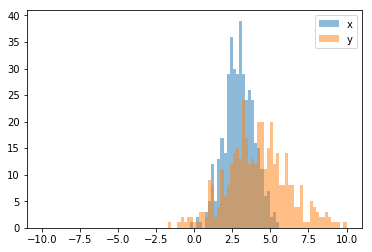

In [56]:
# sample histogram
import random
import numpy
from matplotlib import pyplot

x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

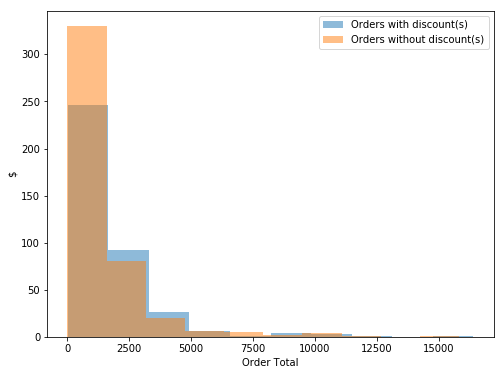

In [57]:
#graph of average order amount, discounted vs. not discounted

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(discount['order_total'], alpha=.5, label='Orders with discount(s)')
ax.hist(no_discount['order_total'], alpha=.5, label='Orders without discount(s)')
ax.set_xlabel("Order Total")
ax.set_ylabel("$")
plt.legend(loc='upper right')

/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


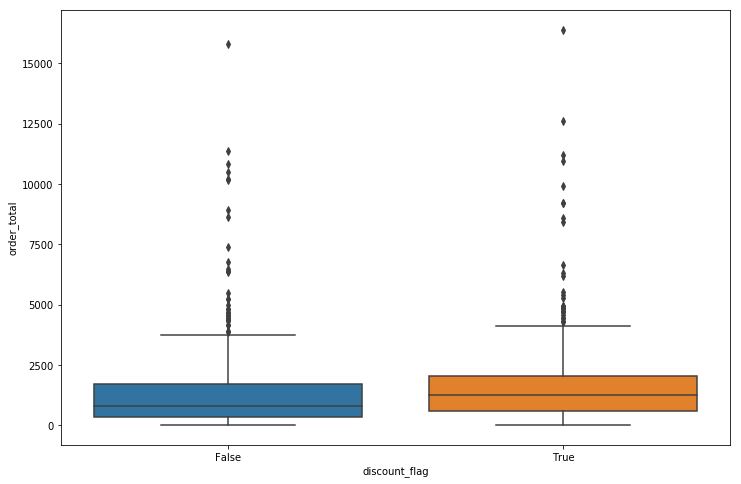

In [58]:
#try box plots
data = pd.concat([orders['order_total'], orders['discount_flag']], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
# fig = sns.boxplot(x='discount_flag', y='order_total', data=data, orient='h')  #???
fig = sns.boxplot(x='discount_flag', y='order_total', data=data)
plt.show()


In [59]:
# discount.head()
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.00,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.40,2,49,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True


As we said previously, scientific experiments actually have 2 hypotheses:


Null Hypothesis: There is no relationship between A and B Example: "There is no relationship between this flu medication and a reduced recovery time from the flu".

The Null Hypothesis is usually denoted as  HOHO 
Alternative Hypothesis: The hypothesis we traditionally think of when thikning of a hypothesis for an experiment Example: "This flu medication reduces recovery time for the flu."

The Alternative Hypothesis is usually denoted as  HaHa 
P-Values and Alpha Values
No matter what you're experimenting on, good experiments come down down to one question: Is our p-value less than our alpha value? Let's dive into what each of these values represents, and why they're so important to experimental design.

P-value: The calculated probability of arriving at this data randomly.

If we calculate a p-value and it comes out to 0.03, we can interpret this as saying "There is a 3% chance that the results I'm seeing are actually due to randomness or pure luck".

αα  (alpha value): The marginal threshold at which we're okay with with rejecting the null hypothesis.

An alpha value can be any value we set between 0 and 1. However, the most common alpha value in science is 0.05 (although this is somewhat of a controversial topic in the scientific community, currently).

If we set an alpha value of  α=0.05α=0.05 , we're essentially saying "I'm okay with accepting my alternative hypothesis as true if there is less than a 5% chance that the results that I'm seeing are actually due to randomness".





In [60]:
# run a hypothesis test comparing orders with discount to those without
# select multiple samples of the orders and look at the distribution of the sample means

no_discount['order_total'].describe()

count      450.000000
mean      1375.331844
std       1792.781223
min         12.500000
25%        360.250000
50%        810.250000
75%       1731.670000
max      15810.000000
Name: order_total, dtype: float64

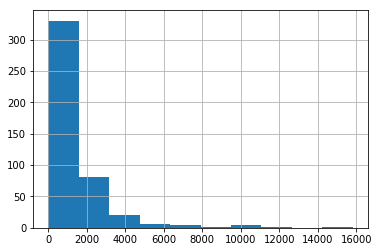

In [61]:
no_discount['order_total'].hist()

In [62]:
''' Random sampling - Random n rows '''
# no_discount_sample = no_discount['order_total'].sample(n=30)
# # print(no_discount_sample)
# no_discount_sample.describe()

# http://www.datasciencemadesimple.com/random-sampling-pandas-python-2/

' Random sampling - Random n rows '

In [63]:
discount['order_total'].describe()

count      380.000000
mean      1702.351789
std       1892.448250
min         23.800000
25%        587.750000
50%       1244.880000
75%       2027.910000
max      16387.500000
Name: order_total, dtype: float64

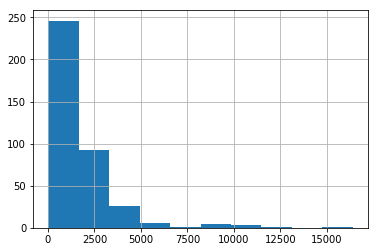

In [64]:
discount['order_total'].hist()

In [65]:
# discount_sample = discount['order_total'].sample(n=30)
# discount_sample.describe()

In [66]:
# create fields for total # of orders, # of orders with a discount, percentage of orders with a discount
# run a hypohtesis test comparing customers with discount vs. no discount, for average value of that customers orders

# calculate the mean and standard deviation for orders with no discount and orders with a discount
# 


# Ho = There is no difference between average order total of orders with any discount(s) and orders with at 
#  least one item discounte.
# Ha = Orders with at least one discounted item have a higher average order total than orders without any discouts.

# alpha = 0.05 . This is the threshold for the p-value that I will use to accept the Ha. If there is a 
# 5% or less probability of obtaining the order total average from the orders with a discount. 
# If the average order total
# for the orders with a total is only 5% likely to be obtained from the samples of the orders with a discount I 
# will 


# mu_2 = the mean order value for orders with a discounted item
# mu_2 = discount.mean()




In [67]:
# funciton to create a ramdom sample of size n from a list

def create_samples(list_of_values, n):
    full_list = []
    while len(full_list) < n:
        random_sample = np.random.choice(list_of_values)
        full_list.append(random_sample)
    return full_list

def create_distribution_of_sample_means(list_of_values, distribution_size, n):
    sample_means = []
    while len(sample_means) < distribution_size:
        sample = create_samples(list_of_values, n)
        sample_mean = np.mean(sample)
        sample_means.append(sample_mean)
#         print("Sample mean # {} done.".format(len(sample_means)))
    return sample_means


In [68]:
# create the list of sample means from both groups
discount_sample_means = create_distribution_of_sample_means(discount['order_total'], 100, 30)
no_discount_sample_means = create_distribution_of_sample_means(no_discount['order_total'], 100, 30)

# calculate the control mean & standard deviation
mu = np.mean(no_discount_sample_means)
sigma = np.std(no_discount_sample_means)

# calculate the treatment mean and number of samples
x_bar = np.mean(discount_sample_means)
n = len(discount_sample_means)

# calculate z-score
z = (x_bar - mu) / (sigma/sqrt(n))

# calcule P-value
p = 1 - stats.norm.cdf(z)


In [69]:
print('Z-score: {:.4f}'.format(z))
print("P-value: {:.12f}".format(p))


Z-score: 9.3432
P-value: 0.000000000000


In [70]:
# use stats built-in t-test
stats.ttest_ind(no_discount_sample_means, discount_sample_means, equal_var=False)


Ttest_indResult(statistic=-6.704238038485551, pvalue=2.0703219567053245e-10)

The very small P-value indicates that it is extremely unlikely that the mean order total from the discounted orders would be randomly obtained from the non-discounted orders. The null hypothesis can be rejected.


In [71]:
# need to calculate cohens d - (effect size), confidence interval, etc. ???


In [72]:
# check how "normal" the distribution of the set of samples is for both groups
print("Normality test of Samples from Non-Discounted Orders:")
print(stats.normaltest(no_discount_sample_means))
print("----")
print("Normality test of Samples from Discounted Orders:")
print(stats.normaltest(discount_sample_means))

Normality test of Samples from Non-Discounted Orders:
NormaltestResult(statistic=12.582848264641616, pvalue=0.0018521204032436477)
----
Normality test of Samples from Discounted Orders:
NormaltestResult(statistic=3.632087596265124, pvalue=0.1626680271617875)


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


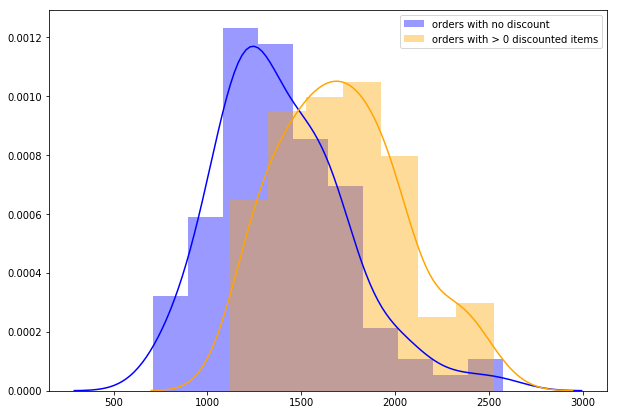

In [73]:
plt.figure(figsize=(10,7))

sns.distplot(no_discount_sample_means, color="blue", label="orders with no discount")
sns.distplot(discount_sample_means, color="orange", label='orders with > 0 discounted items')
plt.legend()


In [74]:
# trying to understand kurtosis test
uniform = list(range(100))
stats.kurtosistest(uniform)


KurtosistestResult(statistic=-5.799128107807834, pvalue=6.666059473262186e-09)

In [75]:
# normal test on the uniform dist
stats.normaltest(uniform)

NormaltestResult(statistic=34.673555743797884, pvalue=2.9561947150806057e-08)

(array([  7.,  21.,  76., 178., 236., 230., 160.,  77.,  10.,   5.]),
 array([-3.17975013, -2.55071848, -1.92168683, -1.29265518, -0.66362353,
        -0.03459189,  0.59443976,  1.22347141,  1.85250306,  2.48153471,
         3.11056635]),
 <a list of 10 Patch objects>)

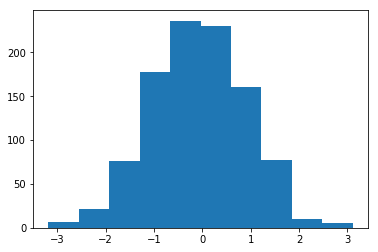

In [76]:
s = np.random.normal(0, 1, 1000)
plt.hist(s)

In [77]:
stats.kurtosistest(s)

KurtosistestResult(statistic=-0.4996702379328554, pvalue=0.6173072921709881)

In [78]:
stats.normaltest(s)

NormaltestResult(statistic=0.7820473411720497, pvalue=0.6763641459141054)

In [79]:
# My analyis above can be for a second question: "Do discounts result in bigger # value orders?"
# I didn't really answer the first question
# Do discounts have a statistically significant effect on the number of products customers order?
# If so, at what level(s) of discount?

# Additinal questions:
# Is the age of customers related to how many different products they have ordered?
# Is the age of customers related to how large their orders are. ie., does average order size increase over time?


In [80]:
# answering question #1:
# pull 

In [130]:
# look at the mean quantity ordered for all products at each level of discount
group_data_1 = pd.DataFrame(order_detail.groupby(['Discount'])['Quantity'].mean())
group_data_1

,Quantity
Discount,
0.00,21.715262
0.01,2.000000
0.02,2.000000
0.03,1.666667
0.04,1.000000
0.05,28.010811
0.06,2.000000
0.10,25.236994
0.15,28.382166


In [132]:
group_data_1.reset_index(inplace=True)

In [133]:
group_data_1

,Discount,Quantity
0,0.00,21.715262
1,0.01,2.000000
2,0.02,2.000000
3,0.03,1.666667
4,0.04,1.000000
5,0.05,28.010811
6,0.06,2.000000
7,0.10,25.236994
8,0.15,28.382166
9,0.20,27.024845


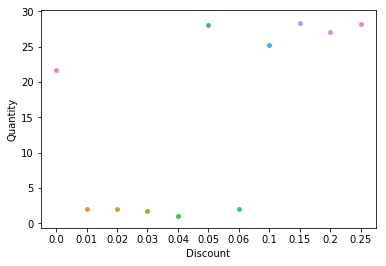

In [135]:
# tips = sns.load_dataset("tips")
# sns.catplot(x="day", y="total_bill", data=tips);

sns.swarmplot(x='Discount', y='Quantity', data=group_data_1)

In [89]:
# this looks at the mean quantity ordered of each product, for each level of discount

group_data = order_detail.groupby(['ProductId', 'Discount'])['Quantity'].mean()
print(group_data)

ProductId  Discount
1          0.00        17.772727
           0.05        20.000000
           0.10        10.000000
           0.15        19.600000
           0.20        42.500000
           0.25        27.800000
2          0.00        21.473684
           0.05        16.666667
           0.10        20.000000
           0.15        25.000000
           0.20        24.700000
           0.25        34.500000
3          0.00        28.800000
           0.10        20.000000
4          0.00        17.200000
           0.05        50.000000
           0.10        22.500000
           0.15        50.000000
           0.20        18.000000
           0.25        27.500000
5          0.00        29.333333
           0.10        15.000000
           0.20        38.500000
           0.25        30.000000
6          0.00        26.750000
           0.02         1.000000
           0.05        33.000000
           0.25        20.000000
7          0.00        29.904762
           0.05        

In [81]:
# # from dsc-0-09-20-1-sample-z-test-online-ds-pt-100118
# x_bar = x.mean() # sample mean
# n = len(x)       # numnber of samples
# mu = 500         # population mean
# sigma = 100      # population standard deviation

# z = (x_bar - mu)/(sigma/sqrt(n))
# z




# from https://towardsdatascience.com/hypothesis-testing-how-to-determine-significance-ce3991c5db53
# create function to sample with replacement
# def get_sample(df, n):
#     sample = []
#     while len(sample) != n:
#         x = np.random.choice(df)
#         sample.append(x)
#     return sample
# # create function to calculate mean of the sample
# def get_sample_mean(sample):
#     return sum(sample)/len(sample)
# # combine functions to create a sample distribution
# # create a distribution size of 1000 and sample size of 500
# def create_sample_distribution(df, dist_size=1000, n=500):
#     sample_dist = [] 
#     while len(sample_dist) != dist_size:
#         sample = get_sample(df, n)
#         sample_mean = get_sample_mean(sample)
#         sample_dist.append(sample_mean)
        
#     return sample_dist
# # create sample distributions of sample mean for control and target
# ctrl_sample = create_sample_distribution(control)
# exp_sample = create_sample_distribution(exp)